### Time Series forecasting of Superstore Sales using ARIMA

In [2]:
#importing necessary packages and libraries
import numpy as np
import pandas as pd
import os
import warnings
import itertools
warnings.filterwarnings(action='ignore')
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
import statsmodels.api as sm

In [3]:
# loading the pre-processed data that we prepared in the EDA notebook- train.csv
data=pd.read_csv('preprocessed_train.csv')
data.head()

,Order Date,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month,Date
0,08-11-2017,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2017,11,8
1,08-11-2017,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2017,11,8
2,12-06-2017,Darrin Van Huff,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2017,6,12
3,11-10-2016,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2016,10,11
4,11-10-2016,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2016,10,11


In [4]:
data.shape

(9983, 18)

In [5]:
## for sales forecasting we only need Order Date and Sales coulmn of the train.csv
features=['Order Date','Sales']
df=data[features]
df.head()

,Order Date,Sales
0,08-11-2017,261.9600
1,08-11-2017,731.9400
2,12-06-2017,14.6200
3,11-10-2016,957.5775
4,11-10-2016,22.3680


In [6]:
df.shape

(9983, 2)

In [7]:
df.info() # here the datatype of the Order Date is object type, so we will convert it into datetime for further modelling.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  9983 non-null   object 
 1   Sales       9983 non-null   float64
dtypes: float64(1), object(1)
memory usage: 156.1+ KB


In [8]:
df.tail()

,Order Date,Sales
9978,21-01-2015,25.248
9979,26-02-2018,91.960
9980,26-02-2018,258.576
9981,26-02-2018,29.600
9982,04-05-2018,243.160


In [9]:
#converting into datetime type
df['Order Date'] = pd.to_datetime(df['Order Date'], errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  9983 non-null   datetime64[ns]
 1   Sales       9983 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 156.1 KB


In [10]:
#setting index
df=df.groupby('Order Date')['Sales'].sum().reset_index()

In [11]:
df

,Order Date,Sales
0,2015-01-02,468.9000
1,2015-01-03,2203.1510
2,2015-01-04,119.8880
3,2015-01-06,5188.5200
4,2015-01-07,601.0240
...,...,...
1230,2018-12-26,814.5940
1231,2018-12-27,177.6360
1232,2018-12-28,1657.3508
1233,2018-12-29,2915.5340


In [12]:
df=df.set_index('Order Date')
df.index

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1235, freq=None)

In [13]:
#using start of each month as timestamp
y=df['Sales'].resample('MS').mean()

In [14]:
y['2015':]

Order Date
2015-01-01    1206.404417
2015-02-01     579.232182
2015-03-01    2029.700222
2015-04-01     988.400640
2015-05-01    1097.771630
2015-06-01    1084.704837
2015-07-01    1413.649840
2015-08-01    1577.272812
2015-09-01    2542.700915
2015-10-01    1382.477880
2015-11-01    2400.652537
2015-12-01    2516.396719
2016-01-01    1630.410356
2016-02-01    1090.965895
2016-03-01    1635.064448
2016-04-01    1585.707021
2016-05-01    1145.693130
2016-06-01    1254.878183
2016-07-01    1218.051130
2016-08-01    1986.505565
2016-09-01    2566.512654
2016-10-01    1186.113889
2016-11-01    1951.242654
2016-12-01    1841.919352
2017-01-01    1653.448818
2017-02-01    2238.109545
2017-03-01    1710.760172
2017-04-01    1738.164538
2017-05-01    2320.154350
2017-06-01    1449.892038
2017-07-01    1645.130577
2017-08-01    1654.999586
2017-09-01    1447.763528
2017-10-01    1935.857407
2017-11-01    2387.056607
2017-12-01    2702.005759
2018-01-01    2563.885240
2018-02-01    2174.412583
2

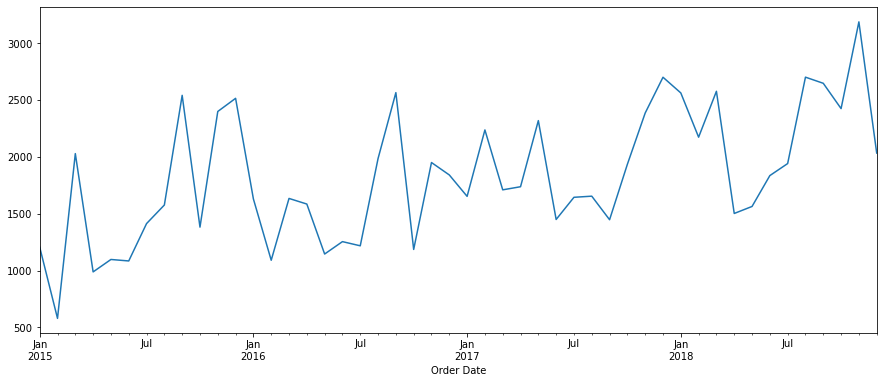

In [15]:
#visualising Sales Time Series Data
y.plot(figsize=(15,6))
plt.show()

### The pattern shows that overall sales goes down around beginning of the year. Also the growth rate of sale has eventually risen from 2015 to 2019. Sales were at peak near the end of 2018.

#### Visualizing the Trends as well as seasonality in the time series data

In [17]:
rcParams['figure.figsize']=19,9

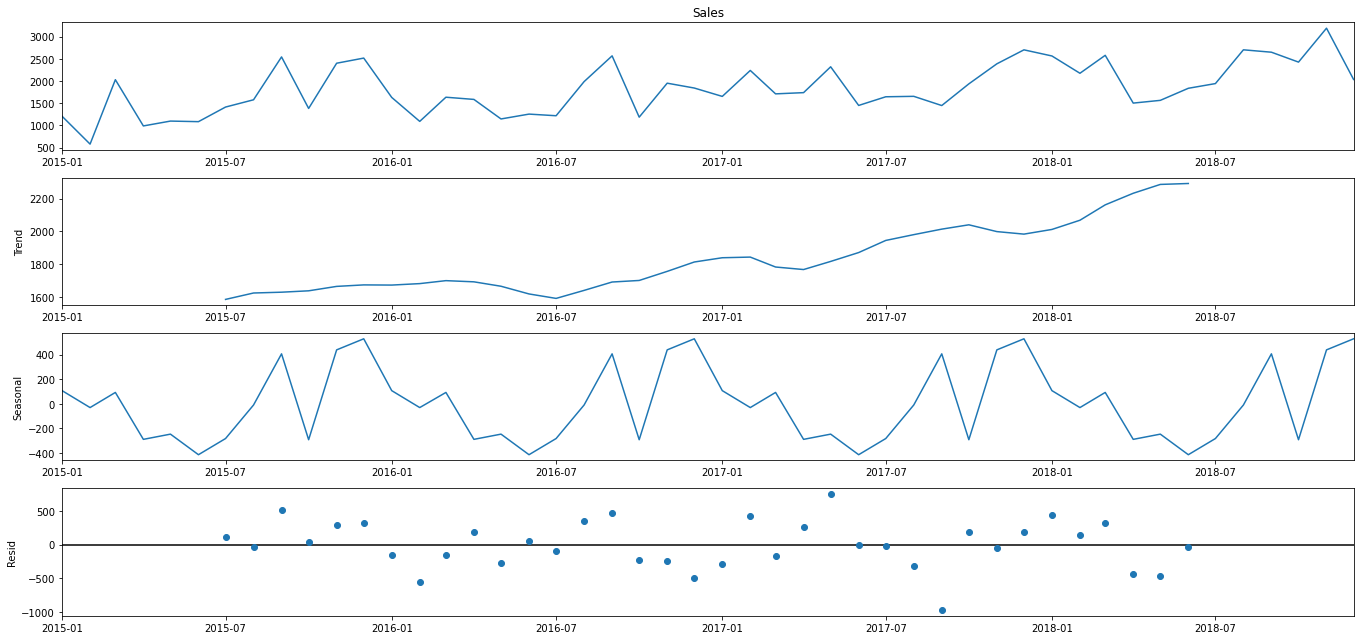

In [18]:
decomp=sm.tsa.seasonal_decompose(y,model='additive')
fig=decomp.plot()
plt.show()

#### The first graph is the OBSERVED one which is the plot we saw in the previous cell output. Second one, shows the trend of the sales data which grow from low to higher across 3 years. Seasonality and Residual plot shows that the sales are quite unstable and need to be scaled for further forecasting.

## Time Series Forecasting with ARIMA

In [19]:
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seas_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [20]:
print('Some of the parameter combinations for Seasonal ARIMA:-')
print('SARIMAX: {} x {}'.format(pdq[1], seas_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seas_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seas_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seas_pdq[4]))


Some of the parameter combinations for Seasonal ARIMA:-
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
#using grid search to find the optimal set of parameters that yields the best performance for our model
#parameter selection for our model
for param in pdq:
    for param_seasonal in seas_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX(y,order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results=mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:846.5283646457178
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1710.1304126359444
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:552.3585479520686
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:370.8136672338749
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:568.0211710599372
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:814.2638444728393
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:385.3587292618705
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:370.0054361124407
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:788.9148100939959
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3449.490533095498
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:537.4302340747481
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:351.1250134045751
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:569.2107277355997
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:606510.8794778839
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:384.60582497223163
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:352.57714581591335
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:725.3445721103578
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:592.1333282492329
ARIMA(0

#### The above output suggests that `ARIMA(1, 1, 1)x(0, 1, 1, 12)12` yields the lowest `AIC` value of 329.44

## Fitting the ARIMA model

In [22]:
mod=sm.tsa.statespace.SARIMAX(y,order=(1,1,1),seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results=mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1198      0.255      0.470      0.639      -0.380       0.620
ma.L1         -1.0001      8.148     -0.123      0.902     -16.970      14.970
ma.S.L12      -1.0334      7.766     -0.133      0.894     -16.254      14.187
sigma2      1.793e+05   4.32e-05   4.15e+09      0.000    1.79e+05    1.79e+05


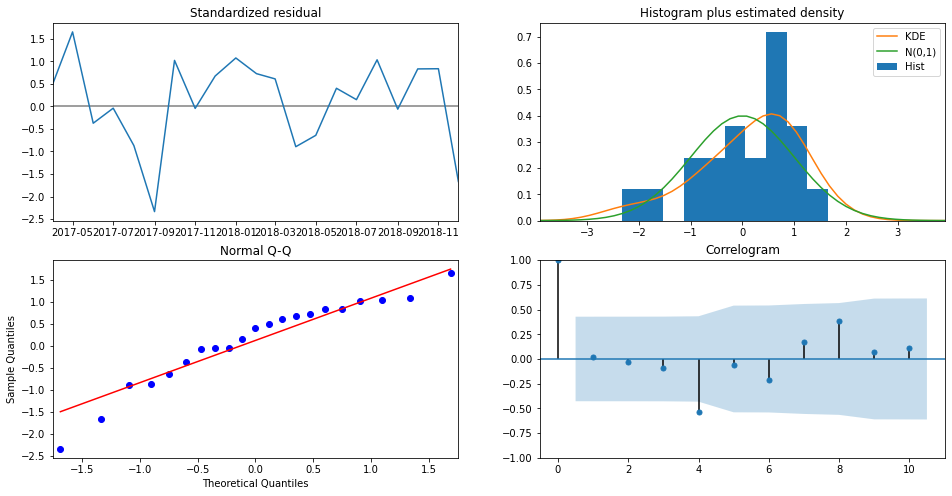

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### The above statistics suggests that our model residuals are approximately normally distributed.

## Model Validation

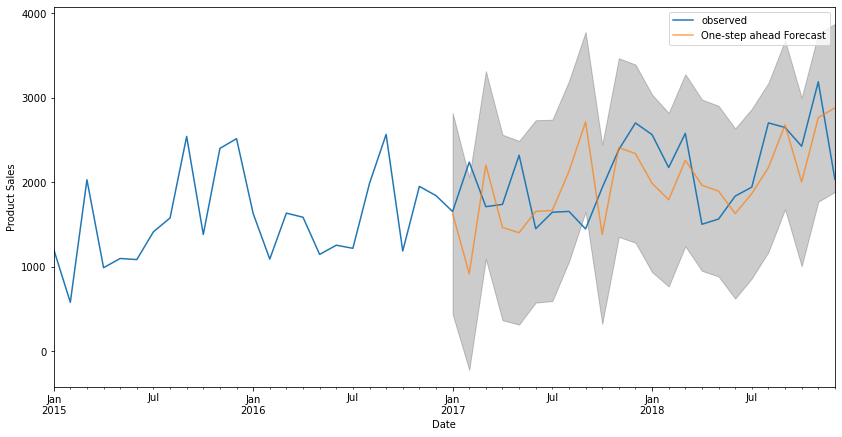

In [24]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()
plt.show()

### The above plot compares the observed versus predicted forecasts in the grey area, and its comes out to be quite approximate.

## Calculating MSE and RMSE of our model

In [25]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

In [26]:
# mse
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 313238.29


In [27]:
# rmse
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 559.68


### The mse and Rmse comes out to be not so good because here we are analyzing overall sales and not product category-wise. But from the overall analysis and validation, the model is working quite good.

### Visualizing forecasts

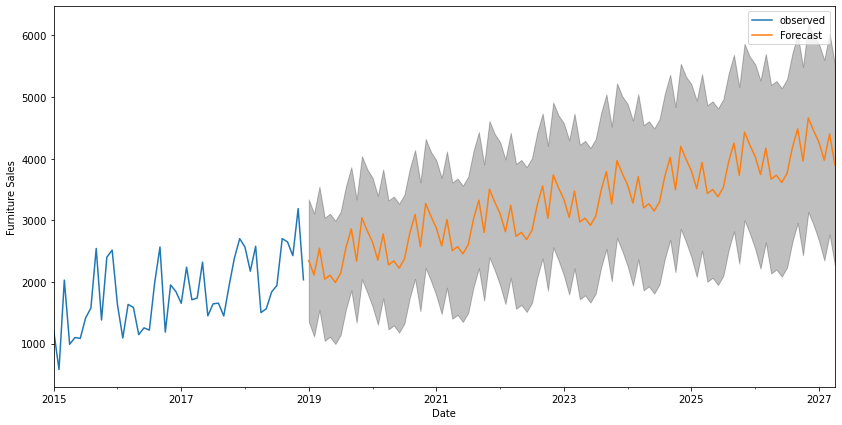

In [28]:
## This shows forecasts for next few years
pred_uc1 = results.get_forecast(steps=100)
pred_ci1 = pred_uc1.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

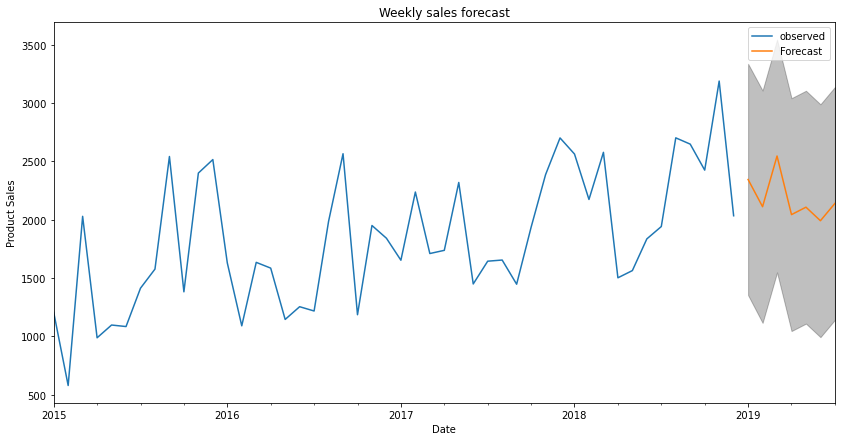

In [29]:
## This shows the forecasts for next 7 days
pred_uc = results.get_forecast(steps=7)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.title('Weekly sales forecast', fontsize=12)
plt.legend()
plt.show()

## Final Table of 7 days Sales forecast

In [30]:
predicted_sale= pred_ci1[:7]

In [31]:
predicted_sale

,lower Sales,upper Sales
2019-01-01,1353.552588,3337.562287
2019-02-01,1116.069339,3108.423475
2019-03-01,1548.863424,3545.279626
2019-04-01,1046.082599,3042.803315
2019-05-01,1109.813805,3106.557620
2019-06-01,993.718325,2990.463965
2019-07-01,1142.028425,3138.774229


#### This is the final output table for next 7 days forecasted sales, and it shows that there will be moderate rise in the sales rate in next 7 days.

### Building the confirmed and predicted Sales table from which we calculated MSE and RMSE
### Y_truth and Y_forecasted table

In [33]:
y_truth.head()

Order Date
2017-01-01    1653.448818
2017-02-01    2238.109545
2017-03-01    1710.760172
2017-04-01    1738.164538
2017-05-01    2320.154350
Freq: MS, Name: Sales, dtype: float64

In [34]:
y_forecasted.head()

Order Date
2017-01-01    1629.940329
2017-02-01     917.829985
2017-03-01    2203.579729
2017-04-01    1465.038130
2017-05-01    1402.793894
Freq: MS, dtype: float64

In [35]:
output = pd.concat([y_truth, y_forecasted], axis=1)

In [36]:
output.head()

,Sales,0
Order Date,,
2017-01-01,1653.448818,1629.940329
2017-02-01,2238.109545,917.829985
2017-03-01,1710.760172,2203.579729
2017-04-01,1738.164538,1465.038130
2017-05-01,2320.154350,1402.793894


In [37]:
s1=pd.Series(output['Sales'],name='Confirmed Sales')
s2=pd.Series(output[0],name='Forecasted Sales')
df_output = pd.concat([s1, s2], axis=1)
df_output

,Confirmed Sales,Forecasted Sales
Order Date,,
2017-01-01,1653.448818,1629.940329
2017-02-01,2238.109545,917.829985
2017-03-01,1710.760172,2203.579729
2017-04-01,1738.164538,1465.038130
2017-05-01,2320.154350,1402.793894
2017-06-01,1449.892038,1655.262178
2017-07-01,1645.130577,1666.605493
2017-08-01,1654.999586,2128.706692
2017-09-01,1447.763528,2715.196594


### From the above table we can analyse that our model is working quite appropriate yielding quite approximate forecasted results. This table is just to compare the forecasted and original results in order to analyze the model performance.